In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time
!pip install wget
import wget
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=a0cc278a51a431774675cf4db8d050341c655ef320ac3bca95a3482ab079eb9a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
wget.download('https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv')
wget.download('https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv')
wget.download('https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv')

'class-descriptions-boxable.csv'

In [3]:
images_boxable_file = 'train-images-boxable-with-rotation.csv'
annotations_bbox_file = 'train-annotations-bbox.csv'
class_descriptions_file = 'class-descriptions-boxable.csv'

In [4]:
images_boxable = pd.read_csv(images_boxable_file)
images_boxable.head()

ImageID Subset                                        OriginalURL  \
0  4fa8054781a4c382  train  https://farm3.staticflickr.com/5310/5898076654...   
1  b37f763ae67d0888  train  https://c1.staticflickr.com/1/67/197493648_628...   
2  7e8584b0f487cb9e  train  https://c7.staticflickr.com/8/7056/7143870979_...   
3  86638230febe21c4  train  https://farm5.staticflickr.com/5128/5301868579...   
4  249086e72671397d  train  https://c6.staticflickr.com/4/3930/15342460029...   

                                  OriginalLandingURL  \
0  https://www.flickr.com/photos/michael-beat/589...   
1  https://www.flickr.com/photos/drstarbuck/19749...   
2  https://www.flickr.com/photos/circasassy/71438...   
3  https://www.flickr.com/photos/ajcreencia/53018...   
4  https://www.flickr.com/photos/codnewsroom/1534...   

                                        License  \
0  https://creativecommons.org/licenses/by/2.0/   
1  https://creativecommons.org/licenses/by/2.0/   
2  https://creativecommons.org/licenses/by/2.0/   
3  https://creativecommons.org/licenses/by/2.0/   
4  https://creativecommons.org/licenses/by/2.0/   

                              AuthorProfileURL        Author  \
0  https://www.flickr.com/people/michael-beat/  Michael Beat   
1    https://www.flickr.com/people/drstarbuck/         Karen   
2    https://www.flickr.com/people/circasassy/    CircaSassy   
3    https://www.flickr.com/people/ajcreencia/          Alex   
4   https://www.flickr.com/people/codnewsroom/  COD Newsroom   

                                               Title  OriginalSize  \
0                                   ...die FNF-Kerze       4405052   
1                               Three boys on a hill        494555   
2  A Christmas carol and The cricket on the heart...       2371584   
3                                    Abbey and Kenny        949267   
4  Suburban Law Enforcement Academy 20th Annivers...       6541758   

                OriginalMD5  \
0  KFukvivpCM5QXl5SqKe41g==   
1  9IzEn38GRNsVpATuv7gzEA==   
2  3hQwu0iSzY1VIoXiwp0/Mg==   
3  onB+rCZnGQg5PRX7xOs18Q==   
4  MjpaAVbMAWbCusSaxI1D7w==   

                                    Thumbnail300KURL  Rotation  
0  https://c1.staticflickr.com/6/5310/5898076654_...       0.0  
1  https://c3.staticflickr.com/1/67/197493648_628...       0.0  
2  https://c7.staticflickr.com/8/7056/7143870979_...       0.0  
3  https://c4.staticflickr.com/6/5128/5301868579_...       NaN  
4  https://c1.staticflickr.com/4/3930/15342460029...       0.0

In [5]:
annotations_bbox = pd.read_csv(annotations_bbox_file)
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

In [6]:
class_descriptions = pd.read_csv(class_descriptions_file, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

In [7]:
# Code for plotting bounding box
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print("")
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      print(f"Class: {class_name}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()


Image: (960, 1280, 3)
Coordinates: (436, 61), (809, 919)
Class: Street light


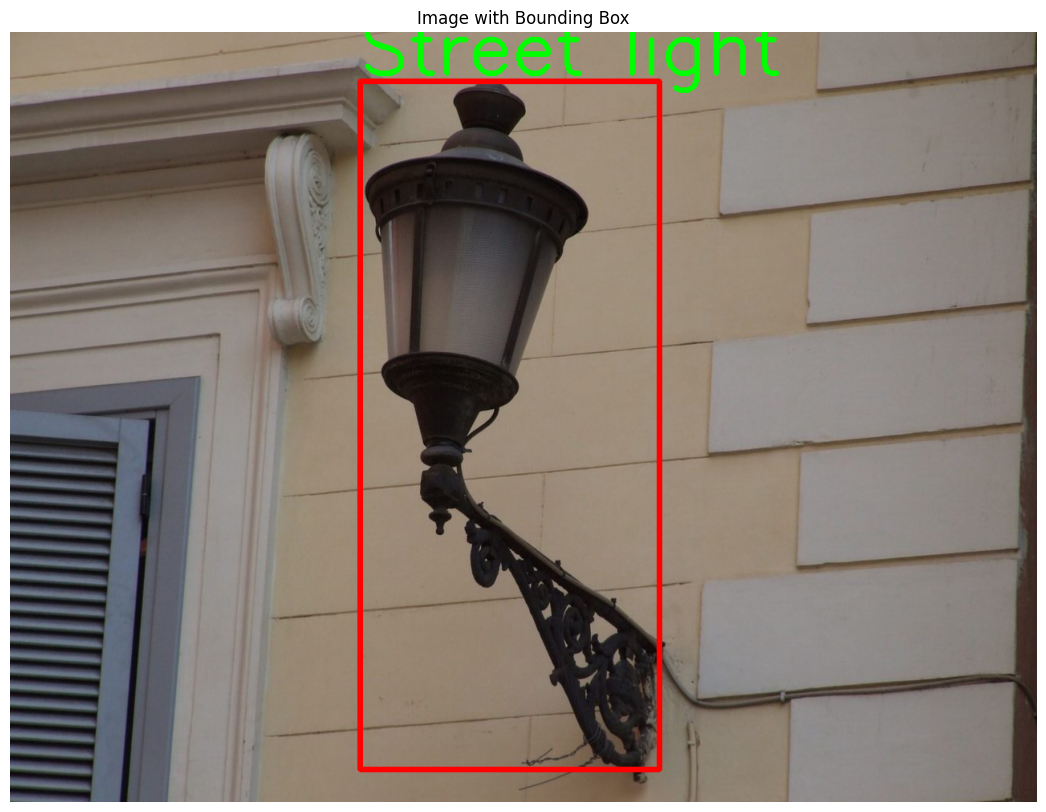


Image: (2298, 3064, 3)
Coordinates: (109, 241), (3064, 2298)
Class: Land vehicle


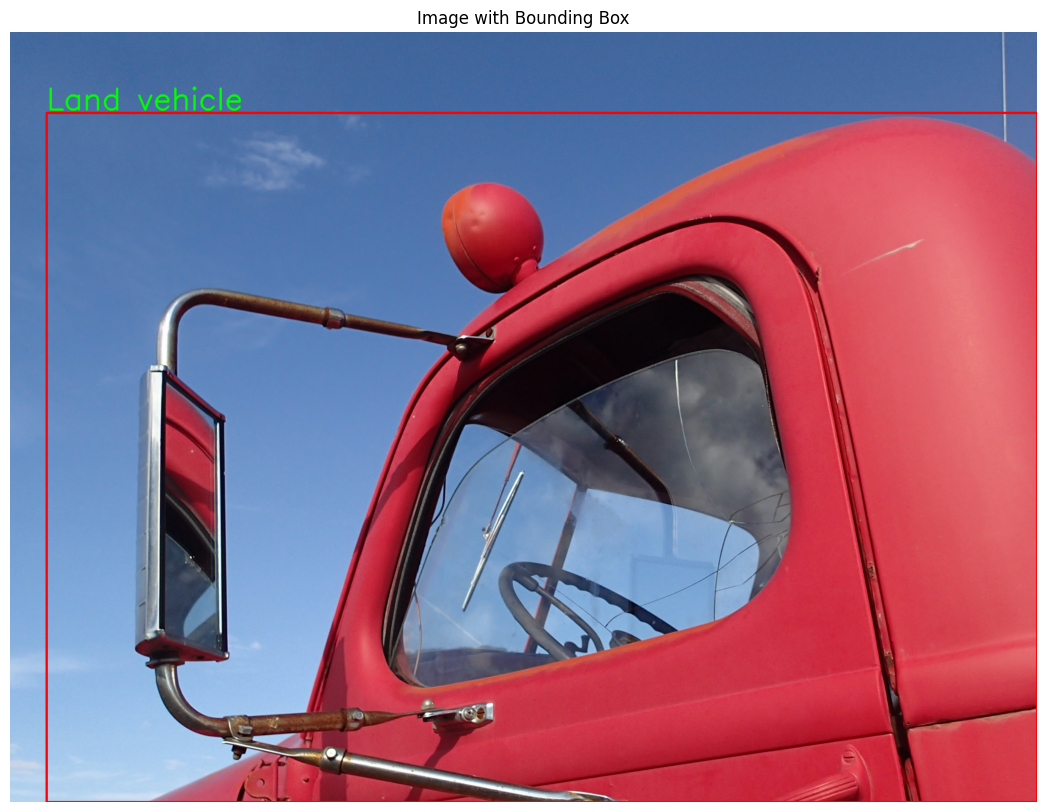


Image: (562, 750, 3)
Coordinates: (135, 147), (527, 303)
Class: Duck


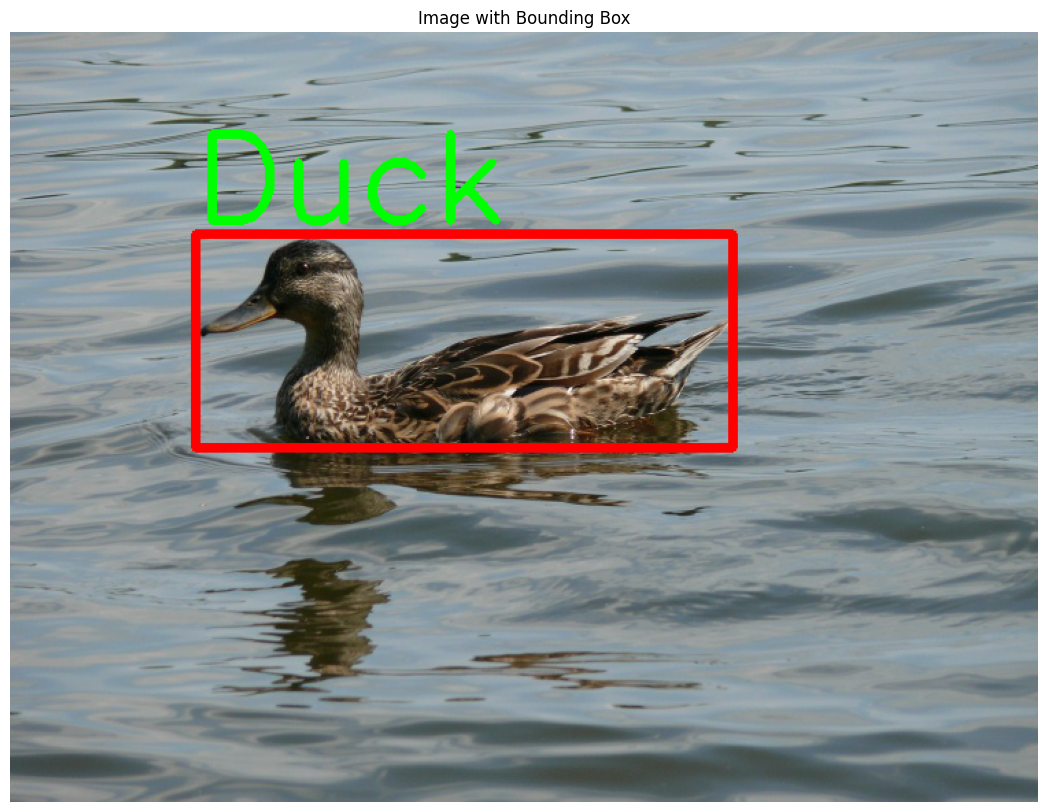


Image: (1496, 2256, 3)
Coordinates: (0, 580), (2254, 1494)
Class: Plant


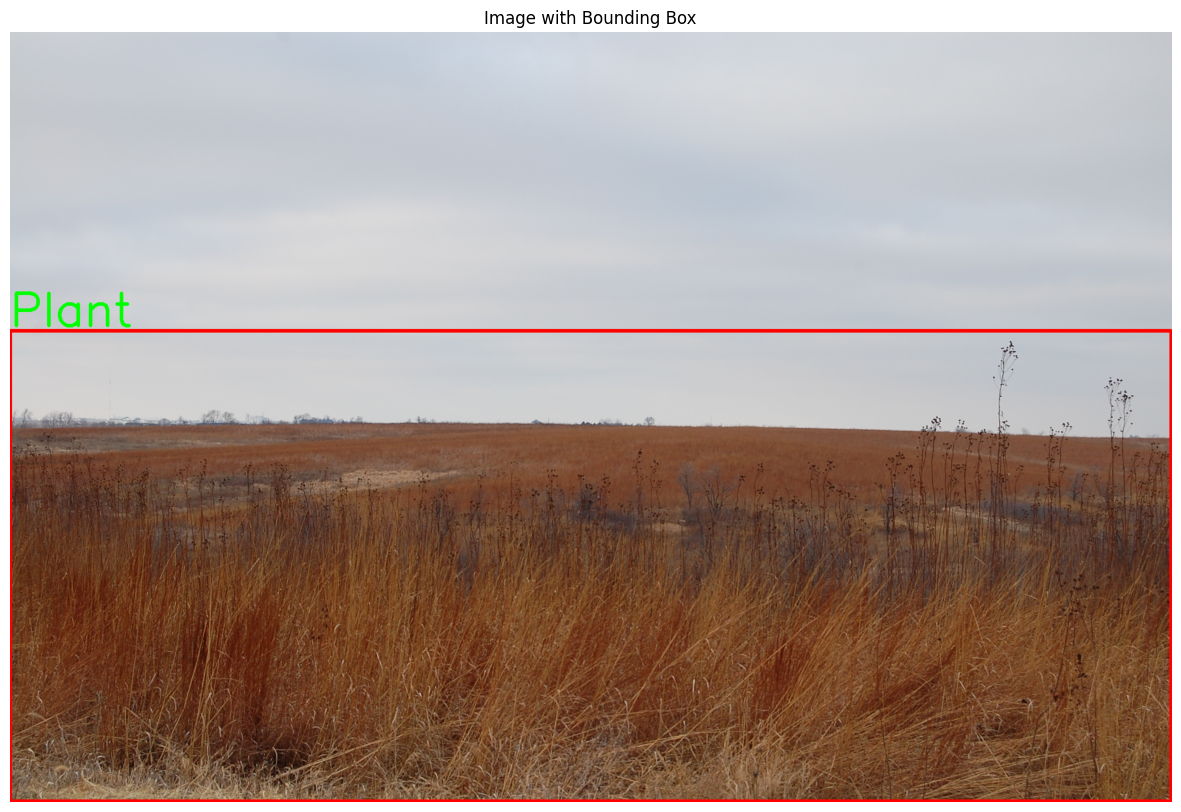


Image: (500, 700, 3)
Coordinates: (12, 97), (644, 365)
Class: Snake


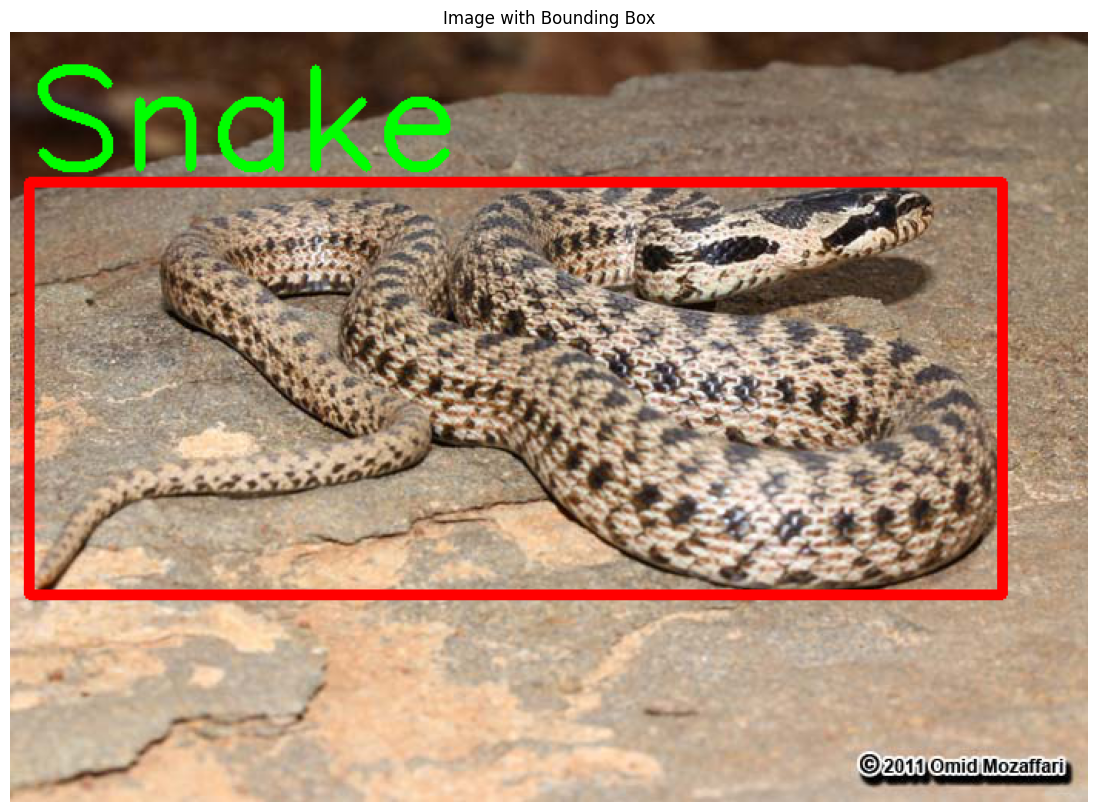

In [8]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

In [9]:
class_descriptions[1].count()

601

In [10]:
cd = class_descriptions.copy()
cd2 = class_descriptions.copy()
lab_2_class_dict = cd.set_index(0).to_dict()[1]
class_2_lab_dict = cd2.set_index(1).to_dict()[0]

In [11]:
lab_2_class_dict["/m/01g317"]

'Person'

In [12]:
class_2_lab_dict['Person']

'/m/01g317'

In [13]:
# Find the label_name for 'Bed', 'Chair' and 'Table' classes
classes = ['Bed','Chair','Table']

In [14]:
bed_bbox = annotations_bbox[annotations_bbox['LabelName']==class_2_lab_dict['Bed']]
chair_bbox = annotations_bbox[annotations_bbox['LabelName']==class_2_lab_dict['Chair']]
table_bbox = annotations_bbox[annotations_bbox['LabelName']==class_2_lab_dict['Table']]

bed_bbox

ImageID     Source  LabelName  Confidence      XMin  \
5953      00041cc3701f7805     xclick  /m/03ssj5           1  0.135112   
5954      00041cc3701f7805     xclick  /m/03ssj5           1  0.179862   
9974      00074503ceae5131     xclick  /m/03ssj5           1  0.000000   
13671     000a54f1bdb96839     xclick  /m/03ssj5           1  0.000000   
17469     000da932ca7e68e4     xclick  /m/03ssj5           1  0.000000   
...                    ...        ...        ...         ...       ...   
14585203  ff7f55b7f6794f63     xclick  /m/03ssj5           1  0.000000   
14595452  ffb716498f082103     xclick  /m/03ssj5           1  0.180000   
14600295  ffce182988b6b746     xclick  /m/03ssj5           1  0.000000   
14602507  ffd718211ba34626  activemil  /m/03ssj5           1  0.006250   
14602925  ffd95054b5fa8ba3     xclick  /m/03ssj5           1  0.000000   

              XMax      YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  \
5953      0.366609  0.420573  0.625000           1            0          0   
5954      0.405336  0.436198  0.856771           0            0          0   
9974      0.999375  0.000000  0.999062           1            1          0   
13671     0.999167  0.028125  0.999375           0            1          0   
17469     0.753125  0.328330  0.993433           1            0          0   
...            ...       ...       ...         ...          ...        ...   
14585203  0.999375  0.000000  0.997500           1            1          0   
14595452  0.998750  0.309568  0.998124           0            0          0   
14600295  0.305625  0.707317  0.999062           0            1          0   
14602507  0.207500  0.373333  0.805000           1            1          0   
14602925  0.928125  0.825000  0.999167           1            1          0   

          IsDepiction  IsInside  
5953                0         0  
5954                0         0  
9974                0         0  
13671               0         0  
17469               0         0  
...               ...       ...  
14585203            0         0  
14595452            0         0  
14600295            0         0  
14602507            0         0  
14602925            0         0  

[3563 rows x 13 columns]

In [15]:
print(f'There are {len(bed_bbox)} beds in the dataset')
print(f'There are {len(chair_bbox)} chairs in the dataset')
print(f'There are {len(table_bbox)} tables in the dataset')

There are 3563 beds in the dataset
There are 132483 chairs in the dataset
There are 85691 tables in the dataset


In [16]:
bed_img_id = bed_bbox['ImageID']
chair_img_id = chair_bbox['ImageID']
table_img_id = table_bbox['ImageID']

In [17]:
# working on 10 images
n = 25
subbed_img_id = random.sample(list(bed_img_id), n)
subchair_img_id = random.sample(list(chair_img_id), n)
subtable_img_id = random.sample(list(table_img_id), n)

In [18]:
subbed_pd = images_boxable.loc[images_boxable['ImageID'].isin(subbed_img_id)]
subchair_pd = images_boxable.loc[images_boxable['ImageID'].isin(subchair_img_id)]
subtable_pd = images_boxable.loc[images_boxable['ImageID'].isin(subtable_img_id)]

In [19]:
print("Beds:",subbed_pd.shape, "Chair:", subchair_pd.shape, "Tables:", subtable_pd.shape)

Beds: (25, 12) Chair: (25, 12) Tables: (25, 12)


In [20]:
subbed_pd.head()

ImageID Subset  \
59419   7e89277c12fdf168  train   
299397  41468d3318bb8d50  train   
375421  9b2ac8c35df3b10f  train   
386599  72fa82779f488a9e  train   
499543  cf21aabdc3dcc244  train   

                                              OriginalURL  \
59419   https://c1.staticflickr.com/1/115/363585964_de...   
299397  https://farm1.staticflickr.com/7135/1397256079...   
375421  https://c8.staticflickr.com/1/41/76640832_68f0...   
386599  https://c7.staticflickr.com/3/2609/3908207916_...   
499543  https://farm5.staticflickr.com/3498/4011457540...   

                                       OriginalLandingURL  \
59419      https://www.flickr.com/photos/sanjoy/363585964   
299397  https://www.flickr.com/photos/cruisesource/139...   
375421     https://www.flickr.com/photos/eridius/76640832   
386599  https://www.flickr.com/photos/bartworldv6/3908...   
499543     https://www.flickr.com/photos/patio/4011457540   

                                             License  \
59419   https://creativecommons.org/licenses/by/2.0/   
299397  https://creativecommons.org/licenses/by/2.0/   
375421  https://creativecommons.org/licenses/by/2.0/   
386599  https://creativecommons.org/licenses/by/2.0/   
499543  https://creativecommons.org/licenses/by/2.0/   

                                   AuthorProfileURL           Author  \
59419         https://www.flickr.com/people/sanjoy/     Sanjoy Ghosh   
299397  https://www.flickr.com/people/cruisesource/  CruiseSource.us   
375421       https://www.flickr.com/people/eridius/    Kevin Ballard   
386599   https://www.flickr.com/people/bartworldv6/      David Jafra   
499543         https://www.flickr.com/people/patio/         Patty Ho   

                                             Title  OriginalSize  \
59419                                      My Room        192485   
299397            Carnival Sunshine: Balcony Cabin       3946216   
375421                              Headless Hands         66988   
386599  Disney's Hotel New York - Disneyland Paris       7753308   
499543                       Saigon Sports 1 hotel        850150   

                     OriginalMD5  \
59419   hsWwjMhvlPp/XVBvt+jCgA==   
299397  WhZ57yAVLG0ZSC1lQ7T5wA==   
375421  bnt3MIO+xFS/Q9pp3e+3vA==   
386599  mmOEVWPwZhvnPYPRRjrxHQ==   
499543  6wCrPU53GtbGhieRj085NA==   

                                         Thumbnail300KURL  Rotation  
59419   https://c7.staticflickr.com/1/115/363585964_de...       0.0  
299397  https://c7.staticflickr.com/8/7135/13972560791...       0.0  
375421  https://c7.staticflickr.com/1/41/76640832_68f0...       0.0  
386599  https://c7.staticflickr.com/3/2609/3908207916_...       0.0  
499543  https://c4.staticflickr.com/4/3498/4011457540_...       0.0

In [21]:
subbed_dict = subbed_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subchair_dict = subchair_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subtable_dict = subtable_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [22]:
mappings = [subbed_dict, subchair_dict, subtable_dict]

In [23]:
len(mappings)

3

In [24]:
len(mappings[0])

25

In [26]:
# download images in folders(Bed, Chair and table folder with 10 images each)


for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 3
Images Issues: 4
Images Issues: 4


##Dataset format for Faster-RCNN code
(fname_path, xmin, xmax, ymin, ymax, class_name)

In [ ]:
# save images to train and test directory, so create 2 folders
train_path = '/content/train'
test_path = '/content/test'
os.makedirs(train_path)
os.makedirs(test_path)

In [32]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)

    limit = int(n*0.8) # 80% data for training and 20% for testing

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]


    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)


    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [29]:
train_img_count = os.listdir('/content/train')
print("Number of images in train found: ", len(train_img_count))

Number of images in train found:  60


In [30]:
test_img_count = os.listdir('/content/test')
print("Number of images in train found: ", len(test_img_count))

Number of images in train found:  4


In [33]:
label_names = [class_2_lab_dict["Bed"] , class_2_lab_dict["Chair"], class_2_lab_dict["Table"]]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name,
                                            'XMin': row['XMin'],
                                            'XMax': row['XMax'],
                                            'YMin': row['YMin'],
                                            'YMax': row['YMax'],
                                            'ClassName': classes[i]},
                                           ignore_index=True)

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pa

<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,
<ipython-input-33-3a2cce552a88>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'FileName': img_name,


In [34]:
train_df.head()

FileName      XMin      XMax      YMin      YMax ClassName
0  8ca9735234a4a7b1.jpg  0.058333  0.556667  0.098750  0.423750     Chair
1  8ca9735234a4a7b1.jpg  0.000000  0.141667  0.634375  0.999375     Chair
2  8ca9735234a4a7b1.jpg  0.000000  0.194167  0.115000  0.431250     Chair
3  8ca9735234a4a7b1.jpg  0.120833  0.212500  0.116875  0.275625     Chair
4  8ca9735234a4a7b1.jpg  0.257500  0.366667  0.105000  0.241250     Chair

In [35]:
train_df.shape

(516, 6)


Image: (3648, 2736, 3)
Coordinates: (159, 360), (1523, 1545)
Class: Chair
Coordinates: (0, 2314), (387, 3645)
Class: Chair
Coordinates: (0, 419), (531, 1573)
Class: Chair
Coordinates: (330, 426), (581, 1005)
Class: Chair
Coordinates: (704, 383), (1003, 880)
Class: Chair
Coordinates: (1028, 369), (1272, 811)
Class: Chair
Coordinates: (1128, 401), (1614, 948)
Class: Chair
Coordinates: (1714, 401), (2733, 1224)
Class: Chair
Coordinates: (1782, 337), (2193, 829)
Class: Chair
Coordinates: (2207, 476), (2733, 991)
Class: Chair
Coordinates: (900, 1632), (1755, 2927)
Class: Cat
Coordinates: (1169, 0), (2118, 909)
Class: Woman
Coordinates: (2250, 0), (2455, 275)
Class: Woman
Coordinates: (0, 6), (248, 807)
Class: Man
Coordinates: (1682, 38), (1983, 275)
Class: Man
Coordinates: (2207, 0), (2733, 1012)
Class: Man
Coordinates: (0, 232), (250, 800)
Class: Clothing
Coordinates: (0, 1016), (319, 2052)
Class: Clothing
Coordinates: (1190, 70), (1865, 873)
Class: Clothing
Coordinates: (1383, 852), (273

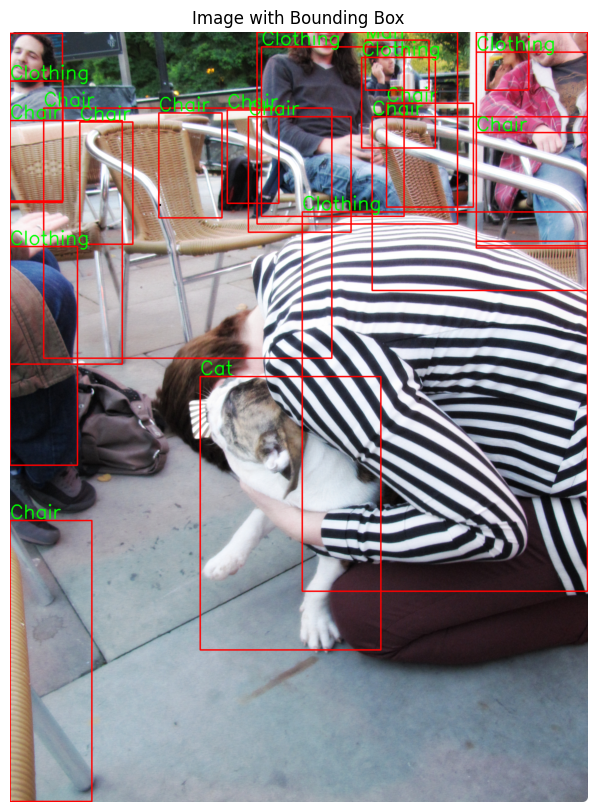

In [36]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique() # plotting the bounding box
for img_id in train_img_ids:
  plot_bbox(img_id)

In [ ]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                val_df = val_df.append({'FileName': img_name,
                                            'XMin': row['XMin'],
                                            'XMax': row['XMax'],
                                            'YMin': row['YMin'],
                                            'YMax': row['YMax'],
                                            'ClassName': classes[i]},
                                           ignore_index=True)

test_df = val_df.copy()

In [47]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

In [48]:
test_df.head()

FileName      XMin      XMax      YMin      YMax ClassName
0  464c01391f7fc116.jpg  0.165625  0.740625  0.675000  0.988889     Table
1  077d4275887d5dda.jpg  0.622271  0.997817  0.656667  0.986667     Table
2  077d4275887d5dda.jpg  0.181223  0.711790  0.600000  0.865000       Bed
3  092db2882619241d.jpg  0.000000  0.999062  0.591250  0.999375       Bed
4  e02b40f2e29aa7de.jpg  0.000000  0.157500  0.145131  0.406367     Table

In [49]:
#Write train.csv to annotation.txt

train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)

      train_file_path = 'D:/5-deep_learning_with_tensorflow/module 7 cnn/7-faster_r-cnn/Faster_r-cnn_demo_youtube/train'
      fileName = os.path.join(train_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [50]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)

      test_file_path = 'D:/5-deep_learning_with_tensorflow/module 7 cnn/7-faster_r-cnn/Faster_r-cnn_demo_youtube/test'
      fileName = os.path.join(test_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')